<a href="https://colab.research.google.com/github/blooming-ai/generativeai/blob/main/linear_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Linear Classification
## Implementation using PyTorch [[1](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html), [2](https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html)]

* Dataset
* Linear Classification Model
* Loss Function
* Training
* Evaluation

In [59]:
import torch
import torch.nn as nn #has all neural network modules
from torch.nn import functional as F # has many functions required for building a neural network
import numpy as np
import matplotlib.pyplot as plt

## Generate Data

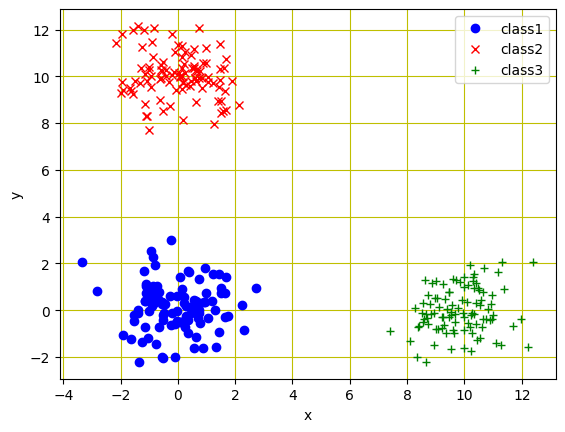

In [85]:
#Generate data
N = 100
ones = torch.ones((N,1), dtype = torch.int64)
class1  = torch.randn((N,2))# (x,y) stacked one below the other
label1 = ones
class2  = torch.randn((N,2)) + torch.tensor([[0,10]]) # addition is broadcasted
label2 = ones*2
class3  = torch.randn((N,2)) + torch.tensor([[10,0]]) # addition is broadcasted
label3 = ones*3
X = torch.cat( (class1, class2, class3), dim = 0) # concatinate data
Y = torch.cat( (label1, label2, label3), dim = 0) # concatinate labels

plt.plot(class1[:,0].numpy(), class1[:,1].numpy(), 'bo', label='class1')
plt.plot(class2[:,0].numpy(), class2[:,1].numpy(), 'rx', label='class2')
plt.plot(class3[:,0].numpy(), class3[:,1].numpy(), 'g+', label='class3')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid('True', color='y')
plt.show()


## Define a Dataset and a Dataloader

In [61]:
from torch.utils.data import Dataset, DataLoader, random_split

class Dataset2D(Dataset):
    def __init__(self, X:torch.tensor, class_labels:torch.tensor):
        self.input = X
        self.class_labels = class_labels
        self.n_labels = torch.max(class_labels).item() # assumes labels are 1,2,3 ..., .item() extracts data from a tensor
        #Create a one hot vector
        self.output = torch.zeros((X.size(0), self.n_labels))
        label_idx = class_labels - 1
        self.output.scatter_(1, label_idx.view(-1,1), 1)

        assert(self.input.shape[0] == self.output.shape[0]) # check if every input has a corresponding output

    def __len__(self):
        return self.input.shape[0]

    def __getitem__(self, idx):
        return self.input[idx,:], self.output[idx,:]

dataset = Dataset2D(X,Y)
# Randomly split a dataset into non-overlapping new datasets of given lengths. Fractions summing up to 1 can be given.
#The lengths will be floor(frac * len(dataset)) for each fraction provided.
training, testing = random_split(dataset, [0.8, 0.2])


#Test
input, output = dataset[0]
print("Sample input: ",input, ", output: ", output)
print("len of training: ", len(training), "len of testing: ", len(testing) )



Sample input:  tensor([-1.1570,  0.1401]) , output:  tensor([1., 0., 0.])
len of training:  240 len of testing:  60


## Define model
### Linear classifier
$y = \mathbf{W} x + \mathbf{b} \qquad
x, b \in \mathbb{R}^2 \;\; y \in \mathbb{R}^3 \;\; W \in \mathbb{R}^{2 \times 3}$

$\text{Soft Max: } z_i = \sigma(y_i)= e^y_i / \sum e^{y_i}$

In [77]:
import pdb
# nn.Module is Base class for all neural network modules. Your models should also subclass this class.
# Modules can also contain other Modules, allowing to nest them in a tree structure.
# You can assign the submodules as regular attributes:
class Linear_Classifier(nn.Module):
    def __init__(self, feature_dim:int = 2, n_labels:int = 3):
        super(Linear_Classifier, self).__init__()
        self.feature_dim = feature_dim
        self.n_labels = n_labels
        self.linear = nn.Linear(self.feature_dim, n_labels ) #(input dim, output dim)

    def forward(self, x):
        y = self.linear(x)
        # pdb.set_trace()
        y = F.softmax(y, dim = 1)
        return y

    @torch.no_grad() # - disables gradient calculation. Useful for inference.
    def evaluate(self, input ):
        self.eval() # Sets the module in evaluation mode.This affects only on certain modules. e.g. Dropout, BatchNorm, etc.
        output_estimate = self(input)
        return output_estimate



### Loss Function
$l(Z, \hat{Z}) = \frac{1}{N}\sum_i (z_i - \hat{z_i})^2$

In [101]:
# Mean Squared Error (MSE) as our loss function.
loss_fun = torch.nn.MSELoss()

### Training

In [95]:
def train(model, loss_fun, optimizer, data_loader, epochs:int = 10):
    '''
    Preform training using the given optimizer to reduce the loss_fun. The data_loader loads the data.
    The training is performed for the number of epochs
    '''
    model.train() # Set to train mode
    history = []
    for epoch in range(epochs):
        # print("===================== epoch: ", epoch,"=======================")
        train_losses = []
        for batch in data_loader:
            input, output = batch
            output_estimate = model(input) # call the forward function

            loss = loss_fun(output_estimate, output)
            # print(loss.item())

            train_losses.append(loss.data.item())
            #Calculate gradient
            loss.backward()
            #Take a step in the negative of gradient direction
            optimizer.step()
            #explicitly set the gradients to zero. Otherwise gradient accumulate.
            optimizer.zero_grad()

        history.extend(train_losses)

    return history


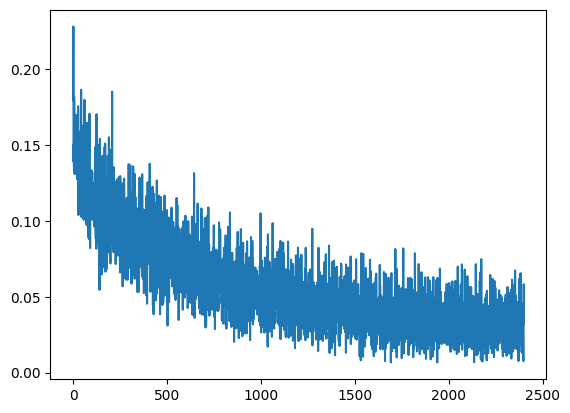

In [102]:
batch_size = 20
learning_rate = 1e-3
epochs = 200

#Instantiate the classifier model
model = Linear_Classifier()

# Reads the dataset into minibatchs. The batches are reshuffled at every epochs
train_dataloader = DataLoader(training, batch_size=batch_size, shuffle=True)

#Define a gradient descent classifier
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)

#Train the classifier
losses = train(model, loss_fun, optimizer, train_dataloader, epochs)
plt.plot(losses)
plt.show()

#Save the model
torch.save(model, "./linear_classifier.pt")

### Evaluation

In [111]:
model = torch.load("./linear_classifier.pt")
misclassified = 0
for test_data, test_output in testing:
    output = model.evaluate(test_data.unsqueeze(dim = 0)).squeeze()
    idx_out = torch.argmax(output).item()
    idx_expected = torch.argmax(test_output).item()
    if idx_out != idx_expected: misclassified += 1

print("Accuracy: ", round(1- misclassified/len(testing),2))

Accuracy:  0.97


### Classifier Lines

In [112]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)

linear.weight tensor([[-1.0729, -0.9390],
        [-0.7005,  0.6821],
        [ 0.5155, -0.6709]])
linear.bias tensor([ 1.5993, -1.4624, -1.4943])
